In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import RandomContrast, RandomZoom, RandomFlip, RandomRotation, RandomTranslation, RandomCrop, RandomBrightness
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ModelCheckpoint

AUTOTUNE = tf.data.AUTOTUNE

#### Loading Dataset


In [6]:
def loadImg(filenames, labels, size, resize, rescale):
    images = []
    for i, name in enumerate(filenames):
        try:
            img = tf.keras.preprocessing.image.load_img(name)
        except:
            labels = np.delete(labels, i)
            continue
        img = tf.cast(img, tf.float32)

        if resize:
            img = tf.image.resize(img, (size, size))

        if rescale == 1:
            img = img / 255
        elif rescale == 2:
            img = (img / 127.5) - 1
        else:
            img = tf.cast(img, tf.uint8)

        images.append(img)
    return images, labels


def parseData(filename, delimiter=',', size=False, resize=False, rescale=True):
    if resize:
        if not size:
            raise Exception('Size must be specified when resize is true.')

    images = []
    train_df = pd.read_csv(str(filename)+"_classes.csv", delimiter=delimiter)
    img_dir = np.array(train_df.pop('filename'))
    img_dir = np.ndarray.flatten(img_dir)

    for row, img_path in enumerate(img_dir):
        img_dir[row] = os.path.join(filename, img_path)

    labels = np.array(train_df.idxmax(axis=1).str.strip().astype(
        'category').cat.codes).reshape(-1, 1)

    images, labels = loadImg(img_dir, labels, size, resize, rescale)

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

In [7]:
disease_dict = {0: 'bacterial_blight', 1: 'Blast',
                2: 'Brownspot', 3: 'leaf_scald', 4: 'leaf_burn', 5: 'tungro'}
img_size = 299

In [5]:
with tf.device('/cpu:0'):
    train_dataset = parseData("./dataset/train/", size=img_size,
                              resize=True, rescale=2)
    valid_dataset = parseData("./dataset/valid/", size=img_size,
                              resize=True, rescale=2)

In [17]:
train = train_dataset.shuffle(512).cache(
    'train_cache').batch(32).prefetch(AUTOTUNE)
valid = valid_dataset.cache().batch(32).prefetch(AUTOTUNE)

In [7]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, input_shape=(img_size, img_size, 3), pooling='max')
base_model.trainable = False

In [8]:
model = Sequential([
    Input((img_size, img_size, 3)),
    RandomFlip(),
    RandomRotation(factor=0.2),
    # RandomZoom(height_factor=(-0.2, 0.2)),
    base_model,
    Dense(512, 'selu'),
    # Dropout(0.2),
    # Dense(256, 'selu'),
    # Dropout(0.2),
    # Dense(32, 'selu'),
    Dense(len(disease_dict.keys()), 'softmax')
])

model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(0.0001),
    metrics=['accuracy']
)

bestCB = ModelCheckpoint(filepath='./checkpoint/best/', monitor='val_accuracy',
                         mode='max', verbose=1, save_best_only=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 299, 299, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 299, 299, 3)      0         
 tion)                                                           
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 22,854,950
Trainable params: 1,052,166
Non-trainable params: 21,802,784
____________________________________

In [32]:
# with tf.device('/cpu:0'):
with tf.device('/gpu:0'):
    history = model.fit(
        train,
        validation_data=valid,
        epochs=10,
        callbacks=bestCB
    )

Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9823
Epoch 1: val_accuracy did not improve from 0.96610
92/92 [==============================] - 18s 192ms/step - loss: 0.0520 - accuracy: 0.9823 - val_loss: 0.1874 - val_accuracy: 0.9492
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9857
Epoch 2: val_accuracy did not improve from 0.96610
92/92 [==============================] - 18s 194ms/step - loss: 0.0455 - accuracy: 0.9857 - val_loss: 0.2003 - val_accuracy: 0.9492
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9802
Epoch 3: val_accuracy did not improve from 0.96610
92/92 [==============================] - 18s 195ms/step - loss: 0.0509 - accuracy: 0.9802 - val_loss: 0.1963 - val_accuracy: 0.9548
Epoch 4/10
92/92 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9894
Epoch 4: val_accuracy did not improve from 0.96610
92/92 [=================

In [33]:
model.save("./checkpoint/latest/")

INFO:tensorflow:Assets written to: ./checkpoint/latest/assets


INFO:tensorflow:Assets written to: ./checkpoint/latest/assets


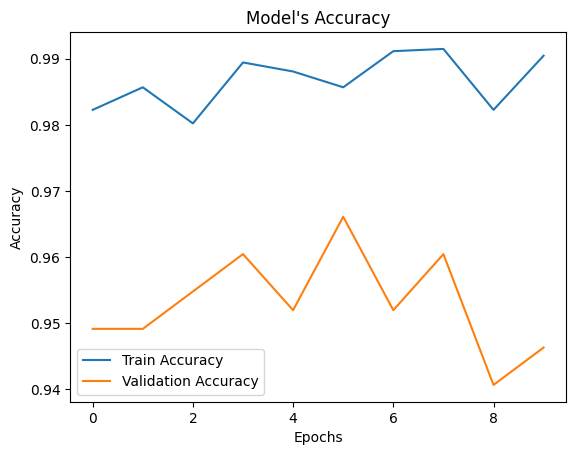

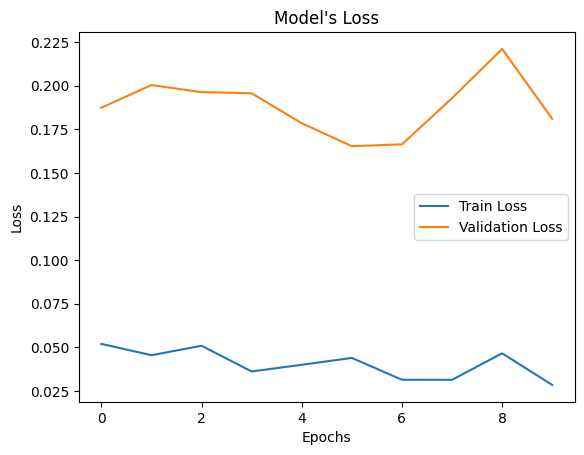

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = history.epoch

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model's Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model's Loss")
plt.legend()
plt.show()

#### Evaluasi Model


In [24]:
# Load iterasi terakhir
# model = tf.keras.models.load_model("./checkpoint/latest/")

# Load terbaik
model = tf.keras.models.load_model("./checkpoint/best/")

In [8]:
with tf.device('/cpu:0'):
    test_dataset = parseData("./dataset/test/", size=img_size,
                             resize=True, rescale=False)

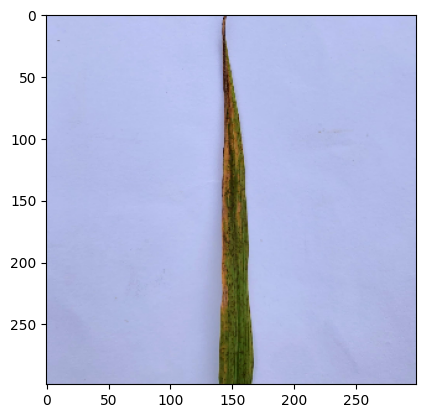

1/1 [==============================] - 1s 1s/step
Label asli: [4]
Prediksi: [5] salah.


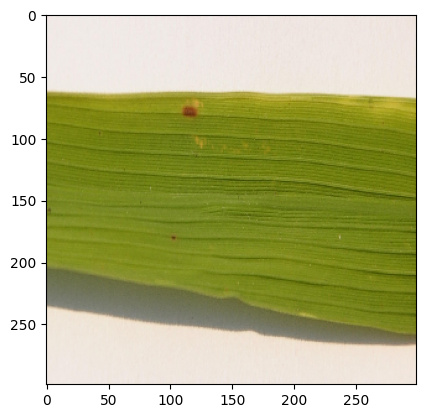

1/1 [==============================] - 0s 112ms/step
Label asli: [2]
Prediksi: [2] benar.


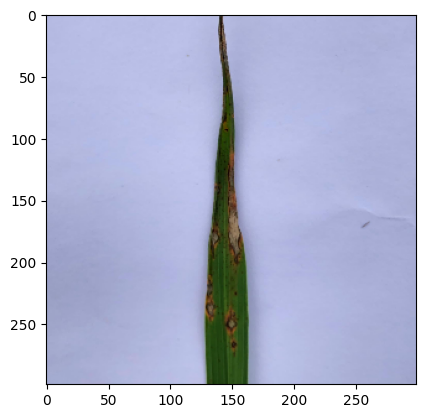

1/1 [==============================] - 0s 98ms/step
Label asli: [1]
Prediksi: [1] benar.


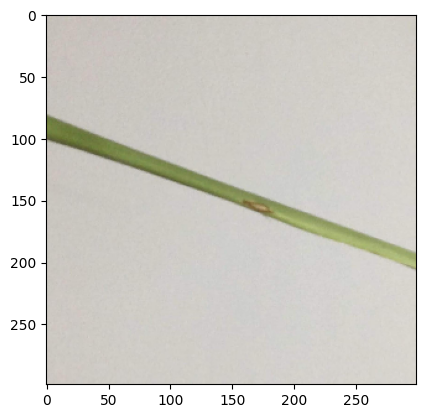

1/1 [==============================] - 0s 99ms/step
Label asli: [1]
Prediksi: [1] benar.


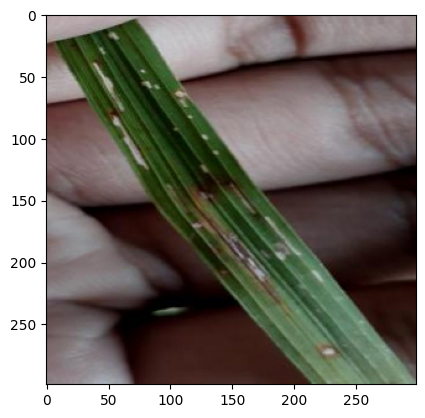

1/1 [==============================] - 0s 103ms/step
Label asli: [1]
Prediksi: [1] benar.


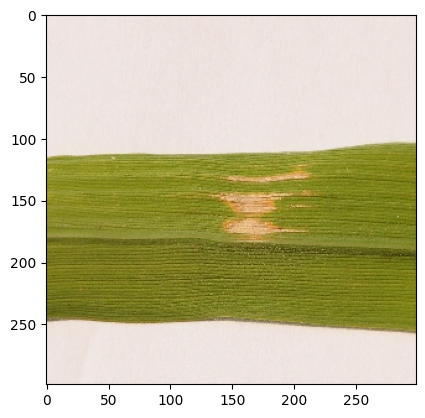

1/1 [==============================] - 0s 99ms/step
Label asli: [0]
Prediksi: [0] benar.


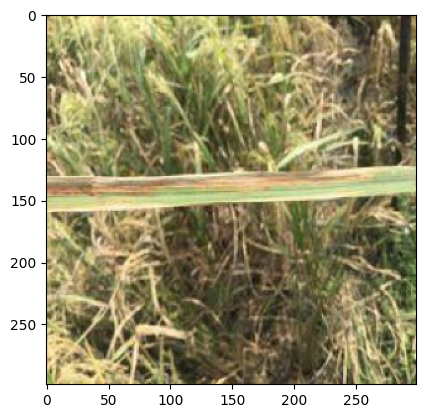

1/1 [==============================] - 0s 98ms/step
Label asli: [0]
Prediksi: [0] benar.


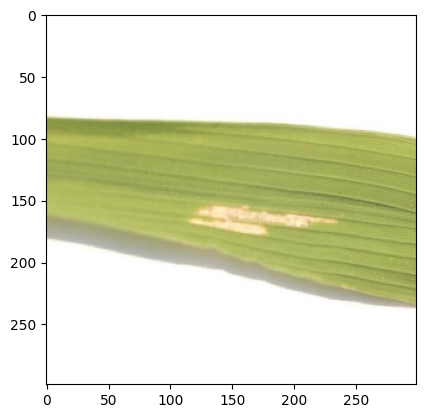

1/1 [==============================] - 0s 97ms/step
Label asli: [0]
Prediksi: [0] benar.


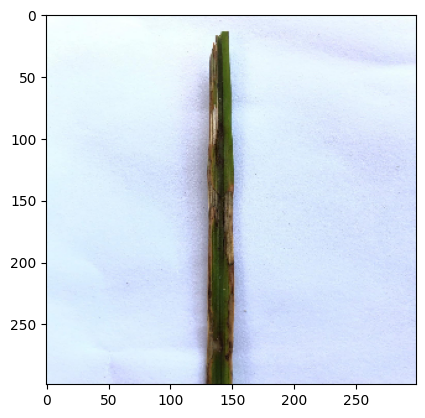

1/1 [==============================] - 0s 97ms/step
Label asli: [0]
Prediksi: [0] benar.


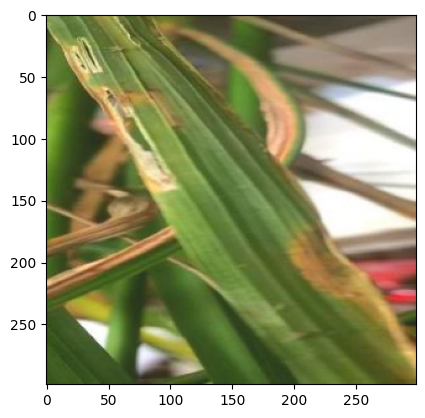

1/1 [==============================] - 0s 105ms/step
Label asli: [0]
Prediksi: [0] benar.


In [25]:
test = test_dataset.shuffle(128).cache().prefetch(AUTOTUNE)

for image, label in test.take(10):
    image = tf.cast(image, tf.uint8)
    plt.imshow(image)
    plt.show()

    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.expand_dims(image, axis=0)
    yhat = model.predict(image)
    yhat = np.argmax(yhat, axis=1)
    result = "benar" if yhat == label else "salah"
    print(f"Label asli: {label}\nPrediksi: {yhat} {result}.")